In [1]:
import os
import sys
import glob
import time 
import pickle
from pathlib import Path
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from data import LiverDataset, blend, Pad, Crop, Resize
from models import UNet, PretrainedUNet
from metrics import jaccard, dice

In [4]:
# 一些参数变量
IMG_HEIGTH, IMG_WIDTH = 512, 512  # 制定图像大小
origin_filename = r"../data/liver_infer/005.png"
# origin_filename = r"data/liver_data/train/images/008.png"

data_folder = Path("data", "liver_data", "train")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("../pretrained")
images_folder = Path("../images")
ckpt_name = "unet_liver_seg_torch{}x{}.pt".format(IMG_HEIGTH, IMG_WIDTH)

In [5]:
ckpt_name

'unet_liver_seg_torch512x512.pt'

In [6]:
# 设置GPU
on_server = False
gpu_ids = '0'
if on_server:
    gpu_ids = '1,2,3,4,5,6'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_ids


# 选择模型
model_name = 'unet_vgg11'
if model_name.lower() in ['unet']:
    net = UNet(in_channels=1, out_channels=2, batch_norm=True)
    ckpt_name = "unet_liver_seg_torch{}x{}.pt".format(IMG_HEIGTH, IMG_WIDTH)
elif model_name.lower() in ['unet_vgg11']:
    net = PretrainedUNet(in_channels=1, out_channels=2, batch_norm=True)
    ckpt_name = "pretrained_unet_liver_seg_torch{}x{}.pt".format(IMG_HEIGTH, IMG_WIDTH)
# net


In [7]:
torch.cuda.empty_cache()

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if len(gpu_ids) > 1:
    net = torch.nn.DataParallel(net)
print('device', device)


device cuda


In [9]:

# 加载权重
model_fn = models_folder / ckpt_name

if on_server:
    net.load_state_dict(torch.load(model_fn, map_location=torch.device("cpu")))
else:
    net.load_state_dict({k.replace('module.',''):v for k,v in torch.load(model_fn).items()})

net.to(device)
net.eval()


PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

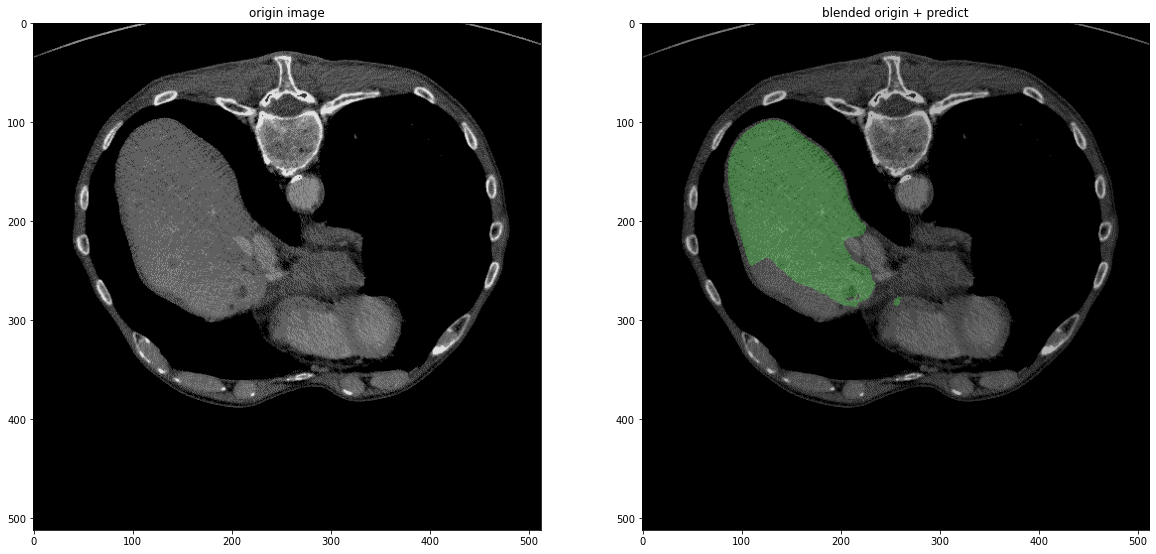

In [10]:


# 加载数据
origin = Image.open(origin_filename).convert("P")
origin = torchvision.transforms.functional.resize(origin, (512, 512))
origin = torchvision.transforms.functional.to_tensor(origin) - 0.5


# 预测
with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = net(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)
    origin = origin[0].to("cpu")
    out = out[0].to("cpu")


# 可视化
plt.figure(figsize=(20, 10))
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")

plt.subplot(1, 2, 1)
plt.title("origin image")
plt.grid(False)
plt.imshow(np.array(pil_origin))

plt.subplot(1, 2, 2)
plt.title("blended origin + predict")
plt.grid(False)
plt.imshow(np.array(blend(origin, out)))
plt.show()

In [11]:
torch.cuda.empty_cache()